In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import numpy as np
import arviz as az
import seaborn as sns

from REStats.utils import load_SCADA, transform, inv_transform
from REStats.models import fit_weibull, calc_persistence, backtest
from REStats.plots import save_figs

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm

In [2]:
sns.set_theme()

In [3]:
wt = load_SCADA(2020)

In [4]:
SAVE_FIGS = True
figs = {}

# Wind -> Wind

This approach takes advantage of the fact that wind speeds follow a Weibull distribution. By fitting the curve to find the shape $\alpha$ and scale $\beta$ parameters, we can apply a transformation to make the curve more Gaussian, after which we can standardize the data before passing it to the model.

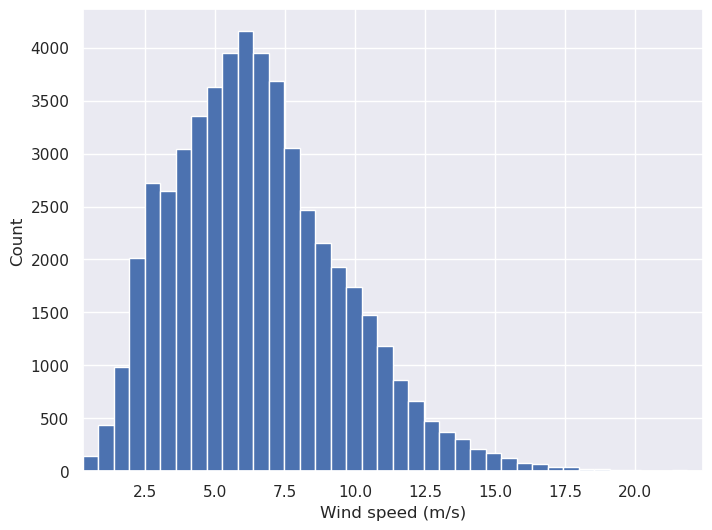

In [5]:
full_ws_hist, ax = plt.subplots(figsize=(8, 6))
ax.set_xmargin(0)
ax.set_xlabel("Wind speed (m/s)")
ax.set_ylabel("Count")

b = ax.hist(wt.wind_speed, bins=40)

figs["full_ws_hist"] = full_ws_hist

In [6]:
wt_1m = wt[(wt.index >= "2020-01-01") & (wt.index < "2020-02-01")]

ws = wt_1m[["wind_speed"]]

# Resample to hourly

ws = ws.resample("H").mean()

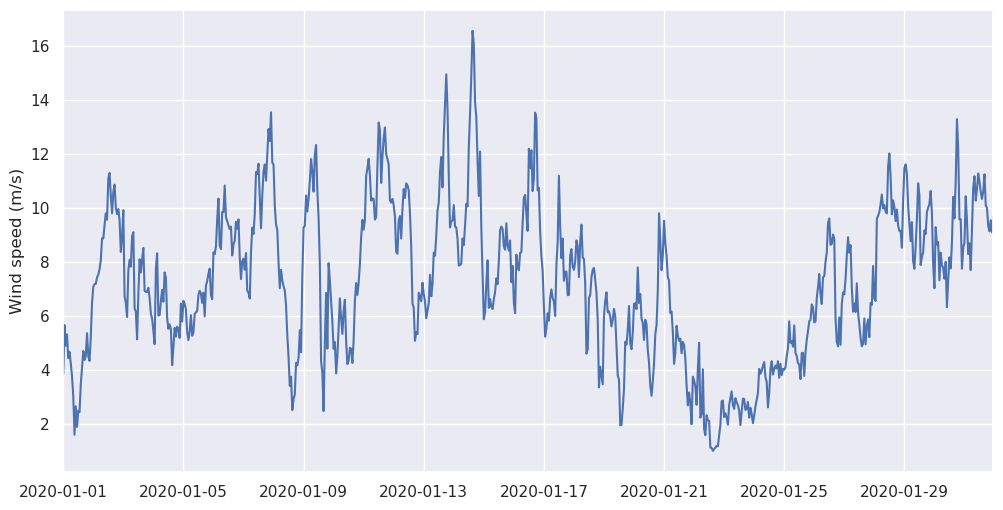

In [7]:
training_raw, ax = plt.subplots(figsize=(12, 6))

ax.set_xmargin(0)
ax.set_ylabel("Wind speed (m/s)")

ax.plot(ws.index, ws)

figs["training_raw"] = training_raw

In [8]:
ws.isnull().sum() == 0, len(ws)

(wind_speed    True
 dtype: bool,
 744)

## Processing: Weibull fit

In order to transform the wind speed distribution to be more Normal, fit the current distribution as Weibull using Bayesian Inference. The resulting shape parameter, $\alpha$, will be used to perform the transformation.

In [9]:
idata_wb = fit_weibull(ws.wind_speed)

/home/cam/mambaforge/envs/REStats/lib/python3.11/site-packages/pyro/infer/mcmc/api.py:497: UserWarning: num_chains=2 is more than available_cpu=1. Chains will be drawn sequentially.
  warnings.warn(
Sample [0]: 100%|█| 1500/1500 [00:11, 132.10it/s, step size=7.18e-01, acc. prob=
Sample [1]: 100%|█| 1500/1500 [00:11, 130.12it/s, step size=8.27e-01, acc. prob=


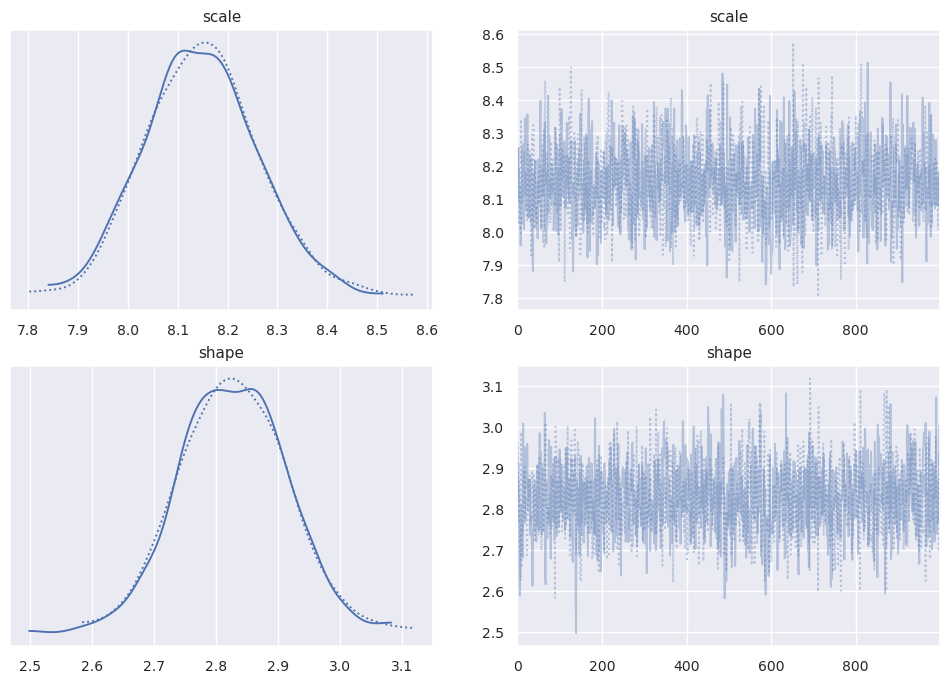

In [10]:
az.plot_trace(idata_wb, figsize=(12, 8))

wb_trace = plt.gcf()
figs["wb_trace"] = wb_trace

In [11]:
az.loo(idata_wb)

Computed from 2000 posterior samples and 744 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -1818.21    16.66
p_loo        2.12        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      744  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [12]:
idata_wb

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

/tmp/ipykernel_20885/860161462.py:10: RuntimeWarning: divide by zero encountered in power
  return (shape / scale) * (x / scale)**(shape - 1) * np.exp(-(x / scale)**shape)


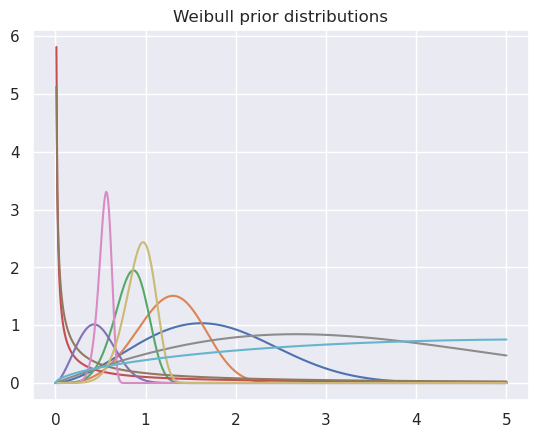

In [13]:
fig, ax = plt.subplots()
ax.set_title("Weibull prior distributions")

shapes = idata_wb.prior.shape[0, :10]
scales = idata_wb.prior.scale[0, :10]

x = np.linspace(0, 5, 500)

def weib(x, scale, shape):
        return (shape / scale) * (x / scale)**(shape - 1) * np.exp(-(x / scale)**shape)

for shape, scale in np.array([shapes, scales]).T:
    ax.plot(x, scale * weib(x, scale, shape))
    
figs["wb_prior"] = fig

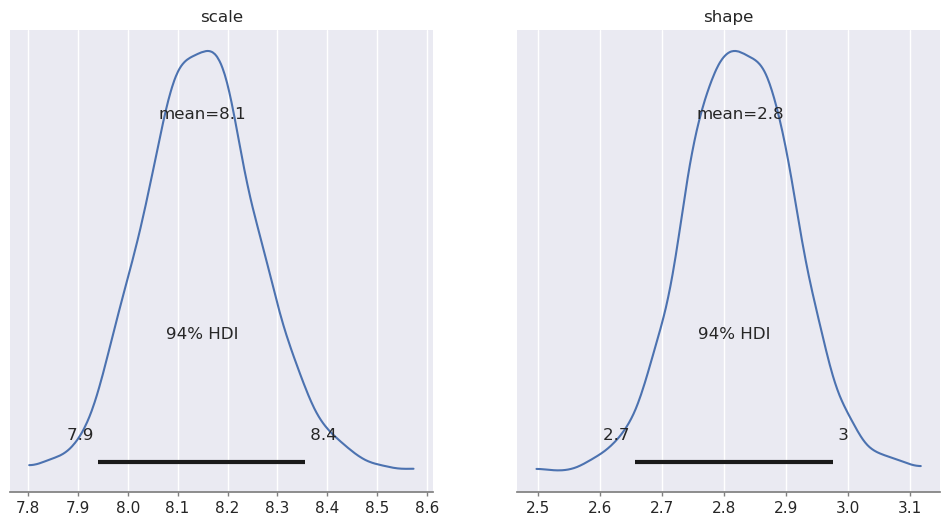

In [14]:
az.plot_posterior(idata_wb, figsize=(12, 6))

wb_posterior = plt.gcf()

figs["wb_posterior"] = wb_posterior

In [15]:
# wb_ppc, ax = plt.subplots(figsize=(8, 6))

# az.plot_ppc(idata_wb, ax=ax)
# ax.set_xlabel("Wind speed (m/s)")

# figs["wb_ppc"] = wb_ppc

We can use the fitted Weibull distribution's shape parameter $\alpha$ to apply a transform to our wind speed data $V$ to make it more Gaussian,

$$
\hat{V} = V^m
$$

where

$$
m = \frac{\alpha}{3.6}
$$

Why 3.6? This is the shape parameter corresponding to a Weibull distribution with Gaussian shape.

In [16]:
shape = idata_wb.posterior.shape.mean(["chain", "draw"]).item(0)
scale = idata_wb.posterior.scale.mean(["chain", "draw"]).item(0)

m = shape / 3.6

print(f"m: {m}")

m: 0.7853019996656145


## Modeling

Autoregressive Moving Average (ARMA) models combine autoregression (AR) and moving average (MA) terms in order to best fit the time series. The ARMA(2, 2) model has been shown in the literature to be highly competitive for short-term wind speed forecasting, though other combinations of p (AR lags) and q (MA lags) may prove better depending on the situation.

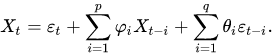

The data transformation includes both the scaling based on Weibull fit, as well as standardization based on mean/std wind speeds for given hours of the day, which helps remove diurnal nonstationarity.

/home/cam/mambaforge/envs/REStats/lib/python3.11/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


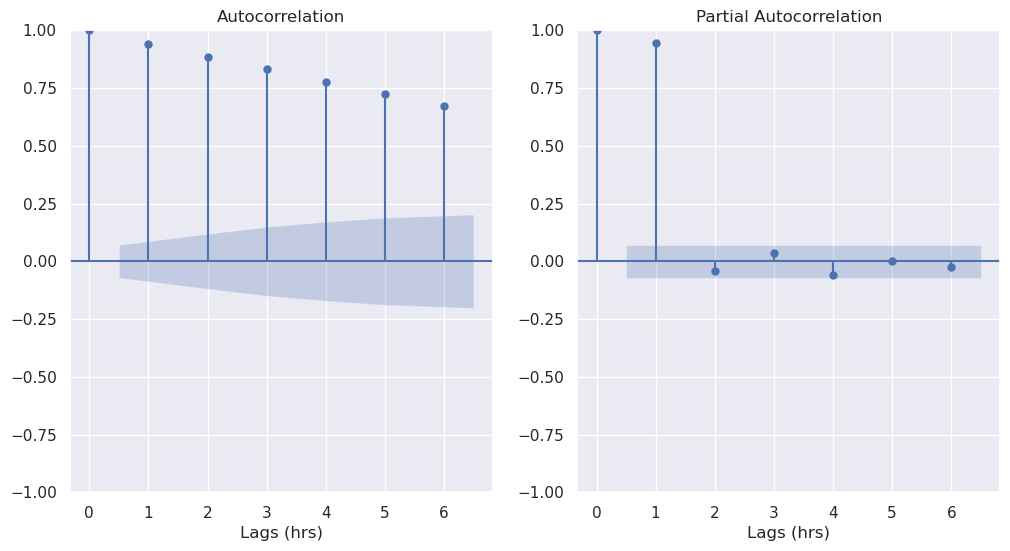

In [17]:
autocorrelation, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].set_xlabel("Lags (hrs)")
axes[1].set_xlabel("Lags (hrs)")

autocorrelation = plot_acf(ws, lags=6, ax=axes[0])
autocorrelation = plot_pacf(ws, lags=6, ax=axes[1])

figs["autocorrelation"] = autocorrelation

In [18]:
ws_tf, hr_stats = transform(ws, m)

ws_tf.head()

,wind_speed,v_scaled,v,hr,v_scaled_std
Date,,,,,
2020-01-01 00:00:00,3.867503,2.892747,3.867503,0,-1.313136
2020-01-01 01:00:00,5.663008,3.902738,5.663008,1,-0.555057
2020-01-01 02:00:00,4.896892,3.481737,4.896892,2,-0.968178
2020-01-01 03:00:00,5.320999,3.716413,5.320999,3,-0.868142
2020-01-01 04:00:00,4.438020,3.222842,4.438020,4,-1.402137


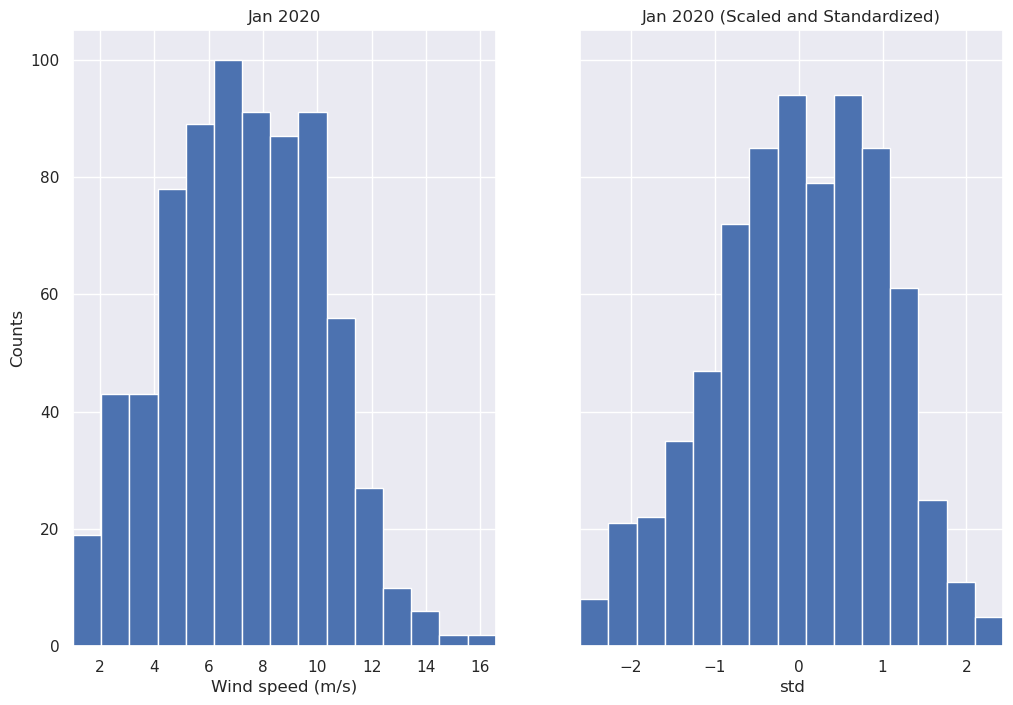

In [19]:
ws_hist_std_comparison, axes = plt.subplots(1, 2, figsize=(12, 8), sharey=True)

[ax.set_xmargin(0) for ax in axes]
axes[0].set_ylabel("Counts")
axes[0].hist(ws_tf.v, bins=15)
axes[0].set_title("Jan 2020")
axes[0].set_xlabel("Wind speed (m/s)")
axes[1].hist(ws_tf.v_scaled_std, bins=15)
axes[1].set_title("Jan 2020 (Scaled and Standardized)")
axes[1].set_xlabel("std")

figs["ws_hist_std_comparison"] = ws_hist_std_comparison

In [20]:
arma_mod = ARIMA(ws_tf.v_scaled_std, order=(2, 0, 2), trend="n")
arma_res = arma_mod.fit()
print(arma_res.summary())

                               SARIMAX Results                                
Dep. Variable:           v_scaled_std   No. Observations:                  744
Model:                 ARIMA(2, 0, 2)   Log Likelihood                -223.609
Date:                Thu, 23 Mar 2023   AIC                            457.218
Time:                        00:19:32   BIC                            480.279
Sample:                    01-01-2020   HQIC                           466.107
                         - 01-31-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4084      0.240      1.702      0.089      -0.062       0.879
ar.L2          0.5138      0.223      2.300      0.021       0.076       0.952
ma.L1          0.5409      0.239      2.266      0.0

In [21]:
pred = arma_res.get_prediction().summary_frame()
pred = pred.copy()
pred

v_scaled_std,mean,mean_se,mean_ci_lower,mean_ci_upper
Date,,,,
2020-01-01 00:00:00,0.000000,0.989454,-1.939295,1.939295
2020-01-01 01:00:00,-1.238977,0.327806,-1.881465,-0.596490
2020-01-01 02:00:00,-0.523384,0.327806,-1.165872,0.119103
2020-01-01 03:00:00,-0.974492,0.326831,-1.615069,-0.333915
2020-01-01 04:00:00,-0.758479,0.326549,-1.398503,-0.118455
...,...,...,...,...
2020-01-31 19:00:00,0.688552,0.326309,0.048998,1.328105
2020-01-31 20:00:00,0.622021,0.326309,-0.017532,1.261575
2020-01-31 21:00:00,0.594486,0.326309,-0.045068,1.234040


Reverse the transformations for error calculations and plotting.

In [22]:
inv_pred = inv_transform(pred, m, hr_stats)
rmse = mean_squared_error(ws_tf.v, inv_pred["mean"], squared=False)
print("RMSE:", rmse)

RMSE: 0.8954636152363679


In [23]:
per = ws_tf.v.shift(1).bfill()
per_rmse = mean_squared_error(ws_tf.v, per, squared=False)
per_rmse

0.9417434296080975

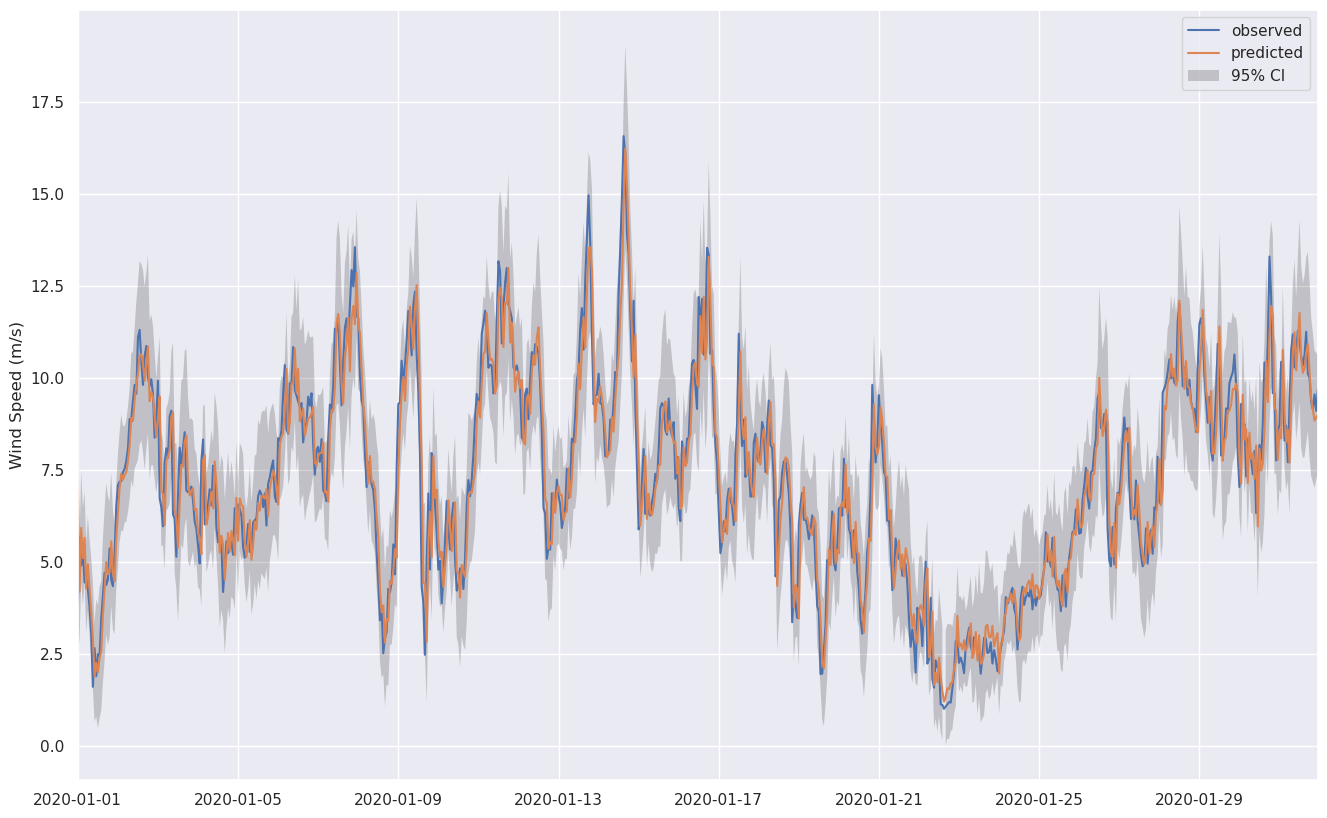

In [24]:
arma_fit_results, ax = plt.subplots(figsize=(16, 10))

ax.set_xmargin(0)
ax.set_ylabel("Wind Speed (m/s)")

ax.plot(ws_tf.index, ws_tf.v, label="observed")

ax.plot(inv_pred.index, inv_pred["mean"], label="predicted")
ax.fill_between(
    inv_pred.index, 
    inv_pred.mean_ci_lower, 
    inv_pred.mean_ci_upper, 
    color="k", alpha=.2, linewidth=0,
    label="95% CI"
)

ax.legend()

figs["arma_fit_results"] = arma_fit_results

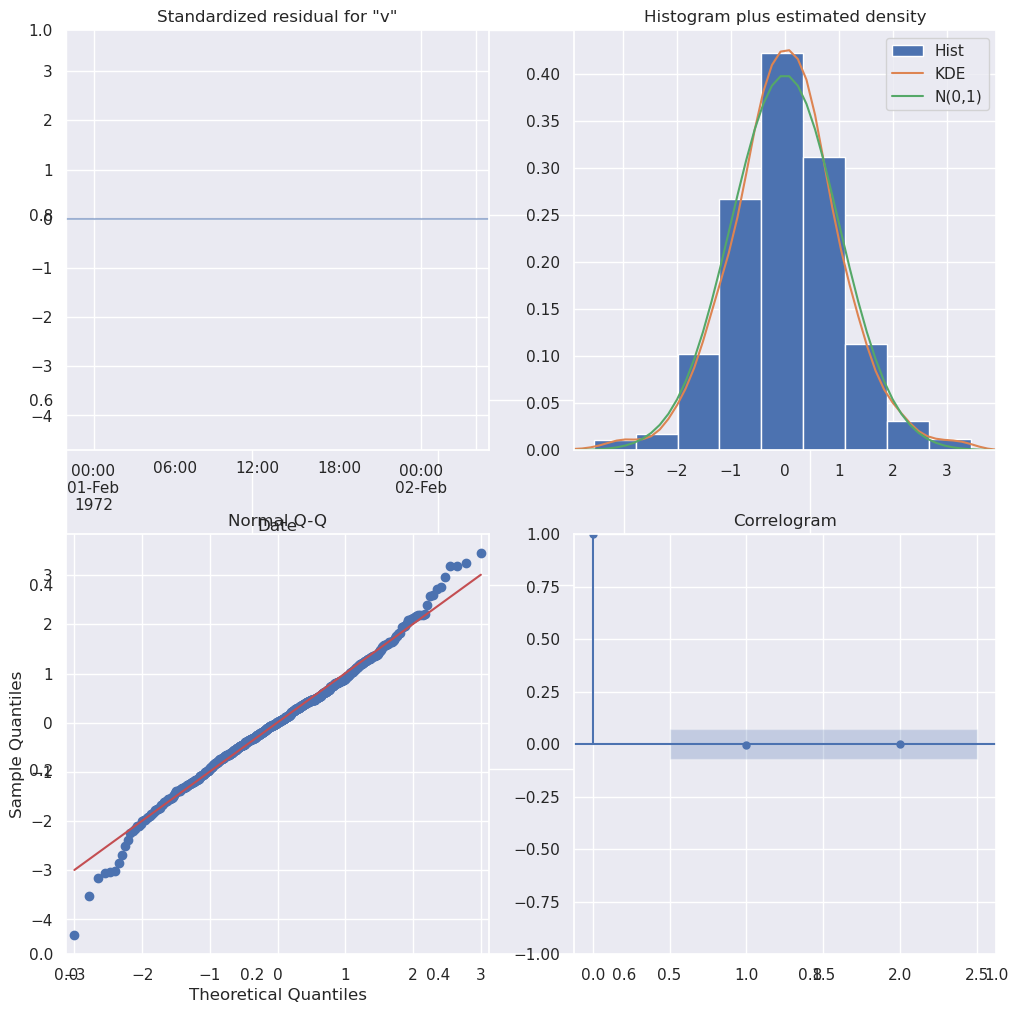

In [25]:
fig, ax = plt.subplots(figsize=(12, 12))

f = arma_res.plot_diagnostics(fig=fig, lags=2)

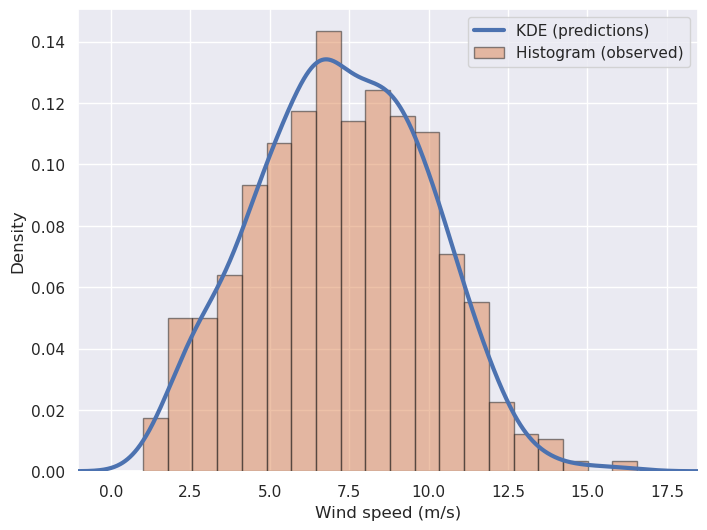

In [26]:
kde = sm.nonparametric.KDEUnivariate(inv_pred["mean"])
kde.fit()  # Estimate the densities

arma_fit_kde, ax = plt.subplots(figsize=(8, 6))
ax.set_xmargin(0)
ax.set_xlabel("Wind speed (m/s)")
ax.set_ylabel("Density")

ax.plot(kde.support, kde.density, lw=3, label="KDE (predictions)", zorder=10)
ax.hist(
    ws_tf.v,
    bins=20,
    density=True,
    label="Histogram (observed)",
    zorder=5,
    edgecolor="k",
    alpha=0.5,
)
ax.legend()

figs["arma_fit_kde"] = arma_fit_kde

## Forecast

In [27]:
wt_train = wt[(wt.index >= "2020-01-01") & (wt.index < "2020-02-01")].copy()
wt_test = wt[(wt.index >= "2020-02-01") & (wt.index < "2020-03-01")].copy()

v_train = wt_train[["wind_speed"]].resample("H").mean()
assert v_train["wind_speed"].isnull().sum() == 0 # sanity check
v_test = wt_test[["wind_speed"]].resample("H").mean()
assert v_test["wind_speed"].isnull().sum() == 0 # sanity check

In [28]:
forecasts_full, (fcast_rmse, fcast_mae) = backtest(v_train, v_test)

forecasts_full.head()

/home/cam/mambaforge/envs/REStats/lib/python3.11/site-packages/pyro/infer/mcmc/api.py:497: UserWarning: num_chains=2 is more than available_cpu=1. Chains will be drawn sequentially.
  warnings.warn(
Sample [0]: 100%|█| 1500/1500 [00:11, 130.86it/s, step size=7.27e-01, acc. prob=
Sample [1]: 100%|█| 1500/1500 [00:11, 130.98it/s, step size=8.09e-01, acc. prob=


Forecast RMSE: 1.2965926924541318
Forecast MAE: 1.005101806442399


v_scaled_std,mean,mean_se,mean_ci_lower,mean_ci_upper
2020-02-01 01:00:00,9.283164,7.695074,7.729076,10.895379
2020-02-01 02:00:00,9.626309,7.987724,7.989679,11.325150
2020-02-01 03:00:00,8.236498,7.957354,6.785106,9.745165
2020-02-01 04:00:00,9.243849,7.818834,7.895337,10.636064
2020-02-01 05:00:00,9.825918,7.794592,8.377051,11.322266


In [29]:
calc_persistence(v_test["wind_speed"])

PER RMSE: 1.262842907899758
PER MAE: 0.9678074320673253


(1.262842907899758, 0.9678074320673253)

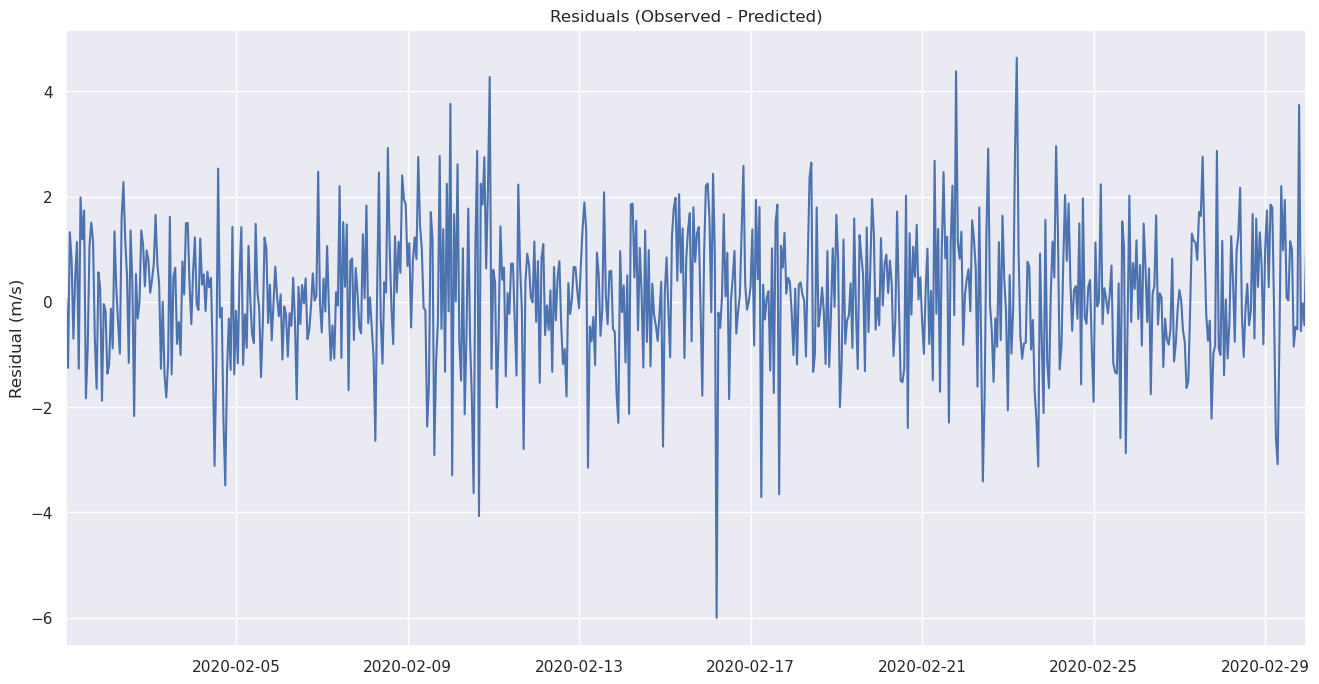

In [30]:
arma_forecast_resid, ax = plt.subplots(figsize=(16, 8))
ax.set_ylabel("Residual (m/s)")
ax.set_xmargin(0)
ax.set_title("Residuals (Observed - Predicted)")

resid = v_test["wind_speed"][1:] - forecasts_full["mean"]

ax.plot(forecasts_full.index, resid)

figs["arma_forecast_resid"] = arma_forecast_resid

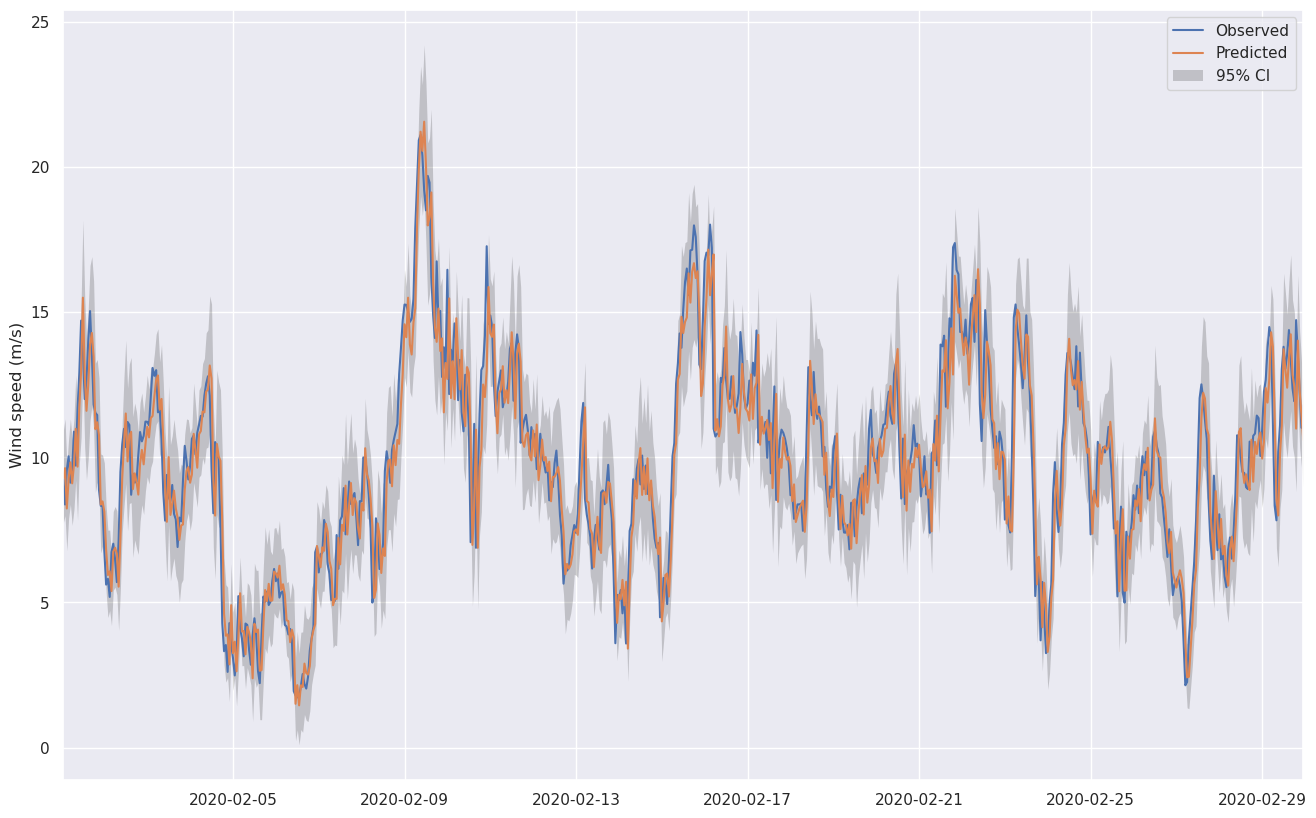

In [31]:
arma_forecast_results, ax = plt.subplots(figsize=(16, 10))
ax.set_xmargin(0)
ax.set_ylabel("Wind speed (m/s)")

ax.plot(v_test.index[1:], v_test[1:], label="Observed")
ax.plot(forecasts_full.index, forecasts_full["mean"], label="Predicted")


ax.fill_between(
    forecasts_full.index, 
    forecasts_full.mean_ci_lower, 
    forecasts_full.mean_ci_upper,
    color="k", alpha=.2, linewidth=0, label="95% CI"
)

ax.legend()

figs["arma_forecast_results"] = arma_forecast_results

In [32]:
if SAVE_FIGS:
    save_figs(figs)